<a href="https://colab.research.google.com/github/xantabdoc/CompoundInterestApplication/blob/master/assignment/PYTN_FINAL_PROJECT_062_RUBEN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Topik yang akan dipakai untuk Manchine ini adalah Classification dengan dataset Titanic

   ## Data Dictionary

| Variable | Definition | Key |
| :--- | :--- | :--- |
| survival |Survival | 0 = No, 1 = Yes |
| pclass | Ticket class | 1 = 1st, 2 = 2nd, 3 = 3rd |
| sex | Sex | |
| Age | Age in years | |
| sibsp | # of siblings / spouses aboard the Titanic | |
| parch | # of parents / children aboard the Titanic| |
| ticket | Ticket number | |
| fare | Passenger fare | |
| cabin | Cabin number | |
| embarked | Port of Embarkation | C = Cherbourg, Q = Queenstown, S = Southampton |


## Variable Notes
pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

# Data Preparation

Load the library you need.

In [ ]:
# Get your import statement here
!apt-get -qq install -y pingouin
!pip install pingouin
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pylab
import pingouin as pg
import pickle

E: Unable to locate package pingouin


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix, plot_roc_curve, roc_curve
from google.colab import drive

In [ ]:
# Load dataset
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/Colab Notebooks/Dataset
test_data = pd.read_csv('test.csv')
main_data = pd.read_csv('train.csv')
g_sub = pd.read_csv('gender_submission.csv')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/Colab Notebooks/Dataset


In [ ]:
main_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
g_sub.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


## EDA

ada nan di age, cabin, dan embarked

In [ ]:
main_data.isna().sum()/len(main_data)*100

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

nan pada cabin terlalu banyak (di atas 50%), kolom cabin akan didrop. jika misal NaN diimpute dengan 'unknown' takutnya model akan menjadi bias

In [ ]:
def report(df):
    col = []
    d_type = []
    uniques = []
    n_uniques = []
    nan = []
    
    for i in df.columns:
        col.append(i)
        d_type.append(df[i].dtypes)
        uniques.append(df[i].unique()[:5])
        n_uniques.append(df[i].nunique())
        nan.append(df[i].isnull().sum())
    
    return pd.DataFrame({'Column': col, 'd_type': d_type, 'unique_sample': uniques, 'n_uniques': n_uniques, 'nan': nan})

In [ ]:
report(main_data)

,Column,d_type,unique_sample,n_uniques,nan
0,PassengerId,int64,"[1, 2, 3, 4, 5]",891,0
1,Survived,int64,"[0, 1]",2,0
2,Pclass,int64,"[3, 1, 2]",3,0
3,Name,object,"[Braund, Mr. Owen Harris, Cumings, Mrs. John B...",891,0
4,Sex,object,"[male, female]",2,0
5,Age,float64,"[22.0, 38.0, 26.0, 35.0, nan]",88,177
6,SibSp,int64,"[1, 0, 3, 4, 2]",7,0
7,Parch,int64,"[0, 1, 2, 5, 3]",7,0
8,Ticket,object,"[A/5 21171, PC 17599, STON/O2. 3101282, 113803...",681,0
9,Fare,float64,"[7.25, 71.2833, 7.925, 53.1, 8.05]",248,0


passangerid, name dan ticket akan di drop karena terrlalu banyak unique dan tidak penting

In [ ]:
main_data.columns = main_data.columns.str.lower()
main_data.drop('name cabin passengerid ticket'.split(), axis=1, inplace=True)

In [ ]:
main_data.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


> ## Age

untuk mengisi age, lihat dulu distribusinya:
 - normal > diisi Mean
 - skew > diisi Median

In [ ]:
main_data.loc[:,'age'].mean()

29.69911764705882

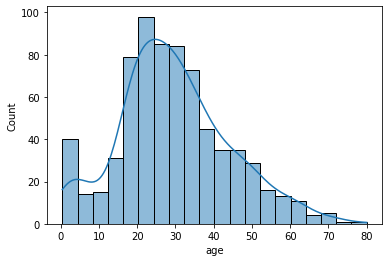

In [ ]:
sns.histplot(main_data.age, kde=True)
plt.show()

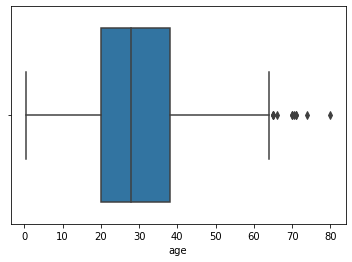

In [ ]:
sns.boxplot(x='age', data=main_data)

Terlihat agak skew, tapi kita bisa buktikan dengan qqplot


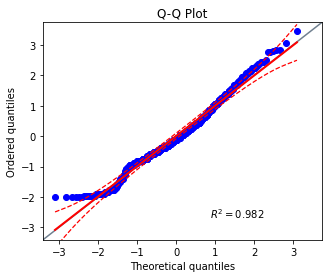

In [ ]:
pg.qqplot(main_data.age, dist='norm')
plt.show()

distribusi terlihat relatif, diimpute dengan mean

> ## Embarked

In [ ]:
main_data.embarked.value_counts()

S    644
C    168
Q     77
Name: embarked, dtype: int64

In [ ]:
main_data[main_data.embarked.isna() == True]

,survived,pclass,sex,age,sibsp,parch,fare,embarked
61,1,1,female,38.0,0,0,80.0,NaN
829,1,1,female,62.0,0,0,80.0,NaN


yang nan cuma ada 2, 2-2 nya sama-sama female dan pclass 1

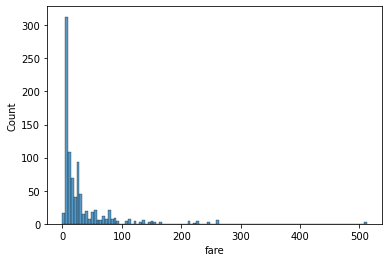

In [ ]:
sns.histplot(main_data.fare)
plt.show()

In [ ]:
#mencari rata2 harga berdasarkan kelas dan tempat keberangkatan

pd.crosstab(index = main_data.embarked, columns = main_data.pclass, values = main_data.fare, aggfunc = np.median)

# karena diliat dr grafik di atas, farenya skew, maka kita pakai median

pclass,1,2,3
embarked,,,
C,78.2667,24.00,7.8958
Q,90.0000,12.35,7.7500
S,52.0000,13.50,8.0500


In [ ]:
#mencari jumlah gender berdasarkan keberangkatan

pd.crosstab(index = main_data.embarked, columns = main_data.sex)

sex,female,male
embarked,,
C,73,95
Q,36,41
S,203,441


dari semua yg female yg dititanic, kebanyaan berangkat dari S

> Age impute dengan median
Embarked impute dengan S

In [ ]:
main_data['age'] = main_data.age.replace(np.nan, main_data.age.mean())
main_data['embarked'] = main_data.embarked.replace(np.nan, 'S')

> # Survived

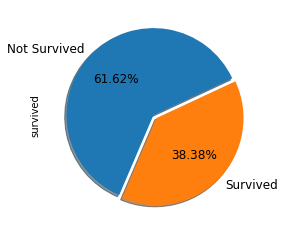

In [ ]:
labels ="Not Survived", "Survived"

main_data.survived.value_counts(normalize = True).plot.pie(explode=[0,0.05], autopct='%1.2f%%', shadow=True, 
                                             labels=labels, fontsize=12, startangle=25)
plt.show()

> ### Survived & Fare

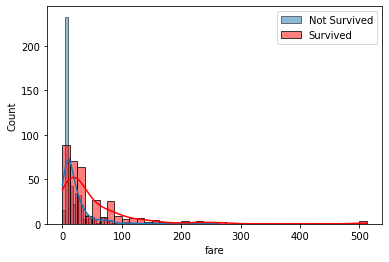

In [ ]:
sns.histplot(main_data[main_data['survived'] == 0]['fare'], label = 'Not Survived', kde=True)
sns.histplot(main_data[main_data['survived'] == 1]['fare'], label = 'Survived', color='r', kde=True)
plt.legend()
plt.plot()
plt.show()

penumpang yang membayar lebih mahal mempunyai peluang untuk selamat yang lebih tinggi dari pada yang membayar agak murah

> ### Survived & Sex

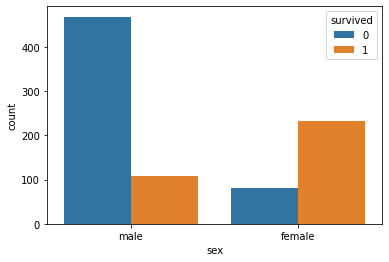

In [ ]:
sns.countplot(x='sex', hue='survived', data=main_data)
plt.show()

lebih banyak female yang selamat dari pada male

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 71.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 48.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


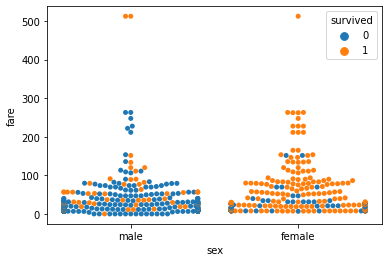

In [ ]:
sns.swarmplot(y='fare', x='sex', hue='survived', data=main_data)
plt.show()

female dari berbagai macam pembayaran lebih cenderung untuk selamat dibanding male

> ### Survived & Siblings

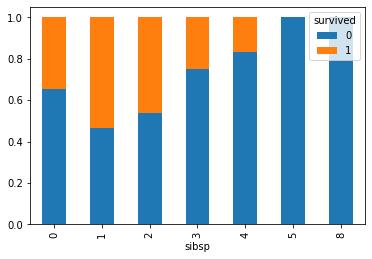

In [ ]:
pd.crosstab(main_data['sibsp'], main_data['survived'], normalize = 0).plot(kind = 'bar', stacked = True)

yg sendirian mempunyai kecenderungan untuk tidak selamat

jika membawa satu, agak cenderung masih selamat

diatas 2, probabilitas untuk tidak selamat semakin tinggi

## Encode

In [ ]:
# karena datanya berbentuk text, kita encoding dulu
df = main_data.copy()
encode = 'sex embarked'.split()
encoder0 = LabelEncoder()
for i in encode:
    df[i] = encoder0.fit_transform(df[i])

df

,survived,pclass,sex,age,sibsp,parch,fare,embarked
0,0,3,1,22.000000,1,0,7.2500,2
1,1,1,0,38.000000,1,0,71.2833,0
2,1,3,0,26.000000,0,0,7.9250,2
3,1,1,0,35.000000,1,0,53.1000,2
4,0,3,1,35.000000,0,0,8.0500,2
...,...,...,...,...,...,...,...,...
886,0,2,1,27.000000,0,0,13.0000,2
887,1,1,0,19.000000,0,0,30.0000,2
888,0,3,0,29.699118,1,2,23.4500,2
889,1,1,1,26.000000,0,0,30.0000,0


## Data Split

In [ ]:
state = 2021
X = df.drop('survived', axis =1)
y = df['survived']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = state)

In [ ]:
logit = LogisticRegression(solver="liblinear", random_state=state)
rfc = RandomForestClassifier(random_state=state)
dtc = DecisionTreeClassifier(random_state = state)
knn = KNeighborsClassifier(n_neighbors=3)
nb = GaussianNB()
svm = SVC(random_state = state)

kolom = ['model', 'score'] 
baris = [] # [[logit, score], [rfc, score], [dtc, score], [knn, score], [nb, score], [svm, score]]
list_model = [logit, rfc, dtc, knn, nb, svm]

for i in list_model:
    i.fit(X_train, y_train) # logit.fit(...)
    y_pred = i.predict(X_test) # y_pred = logit.predict
    score = accuracy_score(y_test,y_pred) # score
    baris.append([i, score]) # rfc, score
    print(i) 
    print("Classification Report")
    print(classification_report(y_test,y_pred))
    print("Confusion Matrix")
    print(confusion_matrix(y_test, y_pred))
    print('-'*40)

df = pd.DataFrame(baris, columns=kolom)
print(df)

LogisticRegression(random_state=2021, solver='liblinear')
Classification Report
              precision    recall  f1-score   support

           0       0.80      0.87      0.83       110
           1       0.76      0.65      0.70        69

    accuracy                           0.79       179
   macro avg       0.78      0.76      0.77       179
weighted avg       0.79      0.79      0.78       179

Confusion Matrix
[[96 14]
 [24 45]]
----------------------------------------
RandomForestClassifier(random_state=2021)
Classification Report
              precision    recall  f1-score   support

           0       0.84      0.85      0.85       110
           1       0.76      0.74      0.75        69

    accuracy                           0.81       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179

Confusion Matrix
[[94 16]
 [18 51]]
----------------------------------------
DecisionTreeClassifier(random_state=2021)
Classi

In [ ]:
df.sort_values('score')

,model,score
5,SVC(random_state=2021),0.698324
2,DecisionTreeClassifier(random_state=2021),0.737430
3,KNeighborsClassifier(n_neighbors=3),0.754190
4,GaussianNB(),0.776536
0,"LogisticRegression(random_state=2021, solver='...",0.787709
1,"(DecisionTreeClassifier(max_features='auto', r...",0.810056


In [ ]:
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
print("Classification Report")
print(classification_report(y_test,y_pred))
print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

Classification Report
              precision    recall  f1-score   support

           0       0.84      0.85      0.85       110
           1       0.76      0.74      0.75        69

    accuracy                           0.81       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179

Confusion Matrix
[[94 16]
 [18 51]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


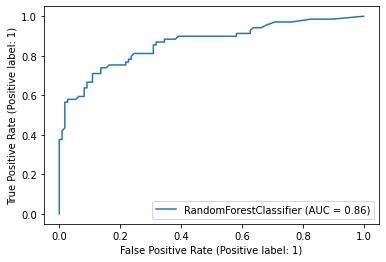

In [ ]:
plot_roc_curve(rfc, X_test, y_test)

score AUC di atas 85 dan dengan akurasi 81%, relatif bagus. kita pakai model ini.

In [ ]:
rfc.fit(X,y)

RandomForestClassifier(random_state=2021)

coba test ke data test

In [ ]:
# Save model

filename = 'rfc.sav'
pickle.dump(rfc, open(filename, 'wb'))

In [ ]:
# Load model

filename = 'rfc.sav'
loaded_model = pickle.load((open(filename, 'rb')))
loaded_model

RandomForestClassifier(random_state=2021)

In [ ]:
test = test_data.copy()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


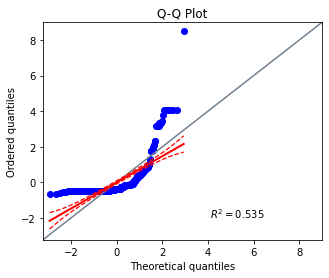

In [ ]:
pg.qqplot(test.Fare, dist='norm')
plt.show()

In [ ]:
#drop kolom yang tidak diperlukan, inpute age dan fare
test.columns = test.columns.str.lower()
test.drop('name cabin passengerid ticket'.split(), axis=1, inplace=True)
test['age'] = test.age.replace(np.nan, test.age.mean())
test['fare'] = test.fare.replace(np.nan, test.fare.median())

In [ ]:
encode = 'sex embarked'.split()
encoder0 = LabelEncoder()
for i in encode:
    test[i] = encoder0.fit_transform(test[i])

test

,pclass,sex,age,sibsp,parch,fare,embarked
0,3,1,34.50000,0,0,7.8292,1
1,3,0,47.00000,1,0,7.0000,2
2,2,1,62.00000,0,0,9.6875,1
3,3,1,27.00000,0,0,8.6625,2
4,3,0,22.00000,1,1,12.2875,2
...,...,...,...,...,...,...,...
413,3,1,30.27259,0,0,8.0500,2
414,1,0,39.00000,0,0,108.9000,0
415,3,1,38.50000,0,0,7.2500,2
416,3,1,30.27259,0,0,8.0500,2


In [ ]:
test_pred = loaded_model.predict(test)

In [ ]:
test_data['survived_predict'] = test_pred
test_data

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,survived_predict
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0
...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,0
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,1
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,0
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,0
